In [1]:
import pandas as pd
import numpy as np
import yaml

# Getting the Data from Config File

In [2]:
config = open("../configs.yaml", 'r')
dictionary = yaml.safe_load(config)

In [3]:
# Data Loading Fields
GRADES_FILENAME = dictionary["data_path"]["grades_filename"]

# Lab Fields
NUM_LABS = dictionary["labs"]["num_labs"]
MAX_LABS = dictionary["labs"]["max_labs"]

# Project Fields
NUM_PROJECTS = dictionary["projects"]["num_projects"]
MAX_PROJECTS = dictionary["projects"]["max_projects"]

NUM_PROJECT_CHECKPOINTS = dictionary["projects"]["num_checkpoints"]
MAX_PROJECT_CHECKPOINTS = dictionary["projects"]["max_checkpoints"]

# Midterm fields
YES_MIDTERM = dictionary["exams"]["midterm"]["enabled"]
MIDTERM_VERSIONS = dictionary["exams"]["midterm"]["versions"]
MIDTERM_BONUS = dictionary["exams"]["midterm"]["bonus"]

# Final Fields
YES_FINAL = dictionary["exams"]["final"]["enabled"]
FINAL_VERSIONS = dictionary["exams"]["final"]["versions"]
FINAl_BONUS = dictionary["exams"]["final"]["bonus"]

# Discussion Fields
NUM_DISC_AND_LECT_ATTENDENCE_REQUIRED = dictionary["discussions"]["num_discussions_and_lecture_attendence_required"]

# Number of dropped assignments per category (set to 0 for no drops)
# For example, if NUM_DROPS = 2, then 2 Labs and 2 Homeworks will be dropped
# Note: Set this to 0 until the end of the quarter
NUM_DROPS = dictionary["drop_policy"]["num_drops"]

OVERALL_EC = dictionary["extra_credit"]["overall"]

ASSIGNMENT_WEIGHTS = dictionary["assignment_weights"]
DISCUSSION_ASSIGNMENT_WEIGHTS = dictionary["discussion_assignment_weights"]

# Late Submission Grace Period (3 Minutes)
GRACE_PERIOD = 3 / 60 

# Reading in the Current Grade CSV

In [4]:
df = pd.read_csv(GRADES_FILENAME)
discussion_and_lecture_attendence = pd.read_csv('../data/attendance_v2.csv').drop(columns=['Email', 'Name'])
df = df.merge(discussion_and_lecture_attendence, on='SID')

# Create name column if not already present
if 'Name' not in df.columns:
    df['Name'] = df['First Name'] + ' ' + df['Last Name']
    df = df.drop(['First Name', 'Last Name'], axis=1)

# Lab 1 Does not have Redemption Assignement 

In [5]:
# At the beginning of the quarter, we did not do Lab 1 Redemption
def redemption_score(lateness, score):
    if lateness != "00:00:00":
        return score
    else:
        return np.nan

df["Lab 1 Redemption"] = df.apply(
    lambda row: redemption_score(row["Lab 1 - Lateness (H:M:S)"], row["Lab 1"]), axis=1
)
df["Lab 1 Redemption - Max Points"] = df["Lab 1 - Max Points"]

# Calculating the Grade for each Assignment

In [7]:
def get_assignment_grade(r, assignment_name):
    num = r[assignment_name]
    den = r[assignment_name + ' - Max Points']
    
    return num / den

In [8]:
for i in range(1, NUM_LABS + 1):
    assignment_name = f"Lab {i}"
    df[assignment_name + " Grade"] = df.apply(
        get_assignment_grade, axis=1, assignment_name=assignment_name
    )
    # if i == 1:
    #     pass

    assignment_name = f"Lab {i} Redemption"
    df[assignment_name + " Grade"] = df.apply(
        get_assignment_grade, axis=1, assignment_name=assignment_name
    )

In [9]:
for i in range(1, NUM_PROJECTS + 1):
    assignment_name = f"Project {i}"
    df[assignment_name + " Grade"] = df.apply(
        get_assignment_grade, axis=1, assignment_name=assignment_name
    )

    assignment_name = f"Project {i} Redemption"
    df[assignment_name + " Grade"] = df.apply(
        get_assignment_grade, axis=1, assignment_name=assignment_name
    )

In [10]:
for i in range(1, NUM_PROJECT_CHECKPOINTS+1):
    assignment_name = f'Project {i} Checkpoint'
    df[assignment_name + ' Final Grade'] = df.apply(get_assignment_grade, axis=1, assignment_name=assignment_name)

# Calculating Final Grade with Redemption Assignments

In [11]:
def final_grade_with_redemption(assignment_name):
    df[f"{assignment_name} Final Grade"] = df[f"{assignment_name} Grade"] + (
        (
            df[f"{assignment_name} Redemption Grade"] - df[f"{assignment_name} Grade"]
        ).apply(lambda x: x if x > 0 else 0)
        * 0.8
    ).fillna(0)

In [12]:
redemptions_assignments = (
    [f"Project {i+1}" for i in range(0, NUM_PROJECTS)]
    + [f"Lab {i+1}" for i in range(0, NUM_LABS)]
)
for assignment in redemptions_assignments:final_grade_with_redemption(assignment) 

# Finding Dropped Lab

In [13]:
def find_dropped_labs(df):
    lab_scores = df[[f'Lab {i} Final Grade' for i in range(1, NUM_LABS+1)]].fillna(0)
    dropped_labs = np.argsort(np.array(lab_scores))[:NUM_DROPS]
    dropped_labs = np.sort(dropped_labs) + 1
    dropped_labs = [f'Lab {l}' for l in dropped_labs]
    return ', '.join(dropped_labs)

df['Dropped Labs'] = df.apply(find_dropped_labs, axis=1)

# Calculating Midterm and Final Grades

In [14]:
if YES_MIDTERM:
    df['Midterm Exam Grade Pre-EC'] = df['Midterm'] / df['Midterm - Max Points']
    df['Midterm Mean'] = df['Midterm Exam Grade Pre-EC'].dropna().mean()
    df['Midterm std'] = df['Midterm Exam Grade Pre-EC'].dropna().std(ddof=0)
    df['Midterm Z-Score'] = (df['Midterm Exam Grade Pre-EC'] - df['Midterm Mean']) / df['Midterm std']
    df['Midterm Exam Grade Post-EC'] = df['Midterm Exam Grade Pre-EC'] + MIDTERM_BONUS  
    if YES_FINAL:
        ...
    else:
       df['Midterm Exam Grade Post-Redemption Post-EC'] = df['Midterm Exam Grade Post-EC'] 

if YES_FINAL:
    # Have to change based on which questions are for Midterm Redemption 
    df['Final Exam Grade'] = df['Final'] / df['Final - Max Points']

# Finding Students who are eligible for Discussion Section

In [15]:
df["Elgible for Discussion"] = (
    df["disc_count"] >= NUM_DISC_AND_LECT_ATTENDENCE_REQUIRED
) & (df["lecture_count"] >= NUM_DISC_AND_LECT_ATTENDENCE_REQUIRED)

# Calculating the Maximum Possible Grade Right Now 

In [20]:
df["Max Possible Points"] = (
    NUM_LABS / MAX_LABS * ASSIGNMENT_WEIGHTS["lab"]
    + NUM_PROJECTS / MAX_PROJECTS * ASSIGNMENT_WEIGHTS["project"]
    + NUM_PROJECT_CHECKPOINTS / MAX_PROJECT_CHECKPOINTS * ASSIGNMENT_WEIGHTS["project_checkpoint"]
)
if YES_MIDTERM:
    df["Max Possible Points"] += ASSIGNMENT_WEIGHTS["midterm_exam"]
if YES_FINAL:
    df["Max Possible Points"] += ASSIGNMENT_WEIGHTS["final_exam"]
df["Max Possible Points"] *= 100
df['Current Max Possible Score'] = df["Max Possible Points"].max()
df['Current Max Possible Score'].max()

57.305555555555564

# Calculating Average Score for Each Assignment Group

## 1 Lab is Dropped

In [21]:
def calculate_lab_mean(row):
    exclude_col = row['Dropped Labs']
    lab_columns = [f"Lab {i+1} Final Grade" for i in range(0, NUM_LABS)]
    columns_to_include = [col for col in lab_columns if col not in [exclude_col, 'Exclude']]
    row_mean = row[columns_to_include].mean()
    return row_mean

In [22]:
df['Lab Average'] = df[[f"Lab {i+1} Final Grade" for i in range(0, NUM_LABS)]].fillna(0).mean(axis=1)
df['Project Average'] = df[[f"Project {i+1} Final Grade" for i in range(0, NUM_PROJECTS)]].fillna(0).mean(axis=1)
df['Project Checkpoint Average'] = df[[f"Project {i+1} Checkpoint Final Grade" for i in range(0, NUM_PROJECT_CHECKPOINTS)]].fillna(0).mean(axis=1)
if YES_MIDTERM:
    df['Midterm Average'] = df['Midterm Exam Grade Post-Redemption Post-EC']
if YES_FINAL:
    df['Final Average'] = df['Final Final']

# Claculating Scores for Each Student Without Discussion

In [23]:
df['Overall Score without Discussion'] = (
    df['Lab Average'] * NUM_LABS / MAX_LABS * ASSIGNMENT_WEIGHTS["lab"]
    + df['Project Average'] * NUM_PROJECTS / MAX_PROJECTS * ASSIGNMENT_WEIGHTS["project"]
    + df['Project Checkpoint Average'] * NUM_PROJECT_CHECKPOINTS / MAX_PROJECT_CHECKPOINTS * ASSIGNMENT_WEIGHTS["project_checkpoint"]
)
if YES_MIDTERM:
    df['Overall Score without Discussion'] += df['Midterm Average'] * ASSIGNMENT_WEIGHTS["midterm_exam"]
if YES_FINAL:
    df['Overall Score without Discussion'] += df['Final Average'] * ASSIGNMENT_WEIGHTS["final_exam"]

df['Overall Score without Discussion'] *= 100

df['Overall Score without Discussion'].max()

53.12932079596517

# Claculating Scores for Each Student With Discussion

In [25]:
df['Overall Score with Discussion'] = (
    df['Lab Average'] * NUM_LABS / MAX_LABS * DISCUSSION_ASSIGNMENT_WEIGHTS["lab"]
    + df['Project Average'] * NUM_PROJECTS / MAX_PROJECTS * DISCUSSION_ASSIGNMENT_WEIGHTS["project"]
    + df['Project Checkpoint Average'] * NUM_PROJECT_CHECKPOINTS / MAX_PROJECT_CHECKPOINTS * DISCUSSION_ASSIGNMENT_WEIGHTS["project_checkpoint"]
)
if YES_MIDTERM:
    df['Overall Score with Discussion'] += df['Midterm Average'] * DISCUSSION_ASSIGNMENT_WEIGHTS["midterm_exam"]
if YES_FINAL:
    df['Overall Score with Discussion'] += df['Final Average'] * DISCUSSION_ASSIGNMENT_WEIGHTS["final_exam"]

df['Overall Score with Discussion'] += DISCUSSION_ASSIGNMENT_WEIGHTS["discussion"]

df['Overall Score with Discussion'] *= 100
df['Overall Score with Discussion'].max()

56.89932079596518

# Finding Current Overall Score

In [26]:
df["Overall Score"] = df.apply(
    lambda row: max(
        row["Overall Score with Discussion"],
        row["Overall Score without Discussion"] * row["Elgible for Discussion"],
    ),
    axis=1,
)

# Calculating Current Grade(Percent / Total Point Possible) for Each Student

In [27]:
df['Current Score'] = df['Overall Score'] / df['Max Possible Points'] * 100


<AxesSubplot:>

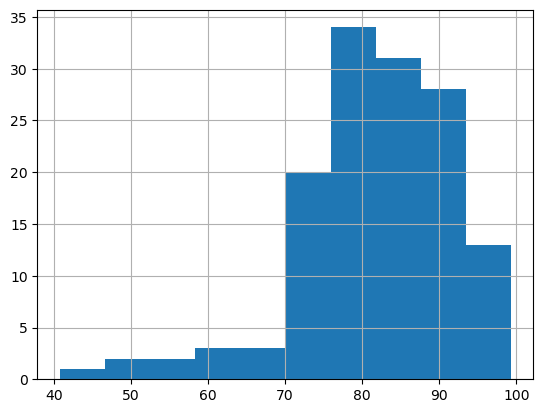

In [29]:
df['Current Score'].hist()

In [30]:
df.to_csv('../data/grades_for_grade_report.csv', index=False)